In [15]:
!pip install kaggle datasketch scikit-learn faiss-cpu langdetect tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
import os

os.environ['KAGGLE_USERNAME'] = "ersultan040403"
os.environ['KAGGLE_KEY'] = "c74b77ebd443fb863a7fa423c3e592d5"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -n amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-books-reviews.zip


In [17]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

USE_SAMPLE = True
NROWS_SAMPLE = 10000
JACCARD_THRESHOLD = 0.8
COSINE_THRESHOLD = 0.85


In [18]:
csv_path = 'Books_rating.csv'

df_test = pd.read_csv(csv_path, nrows=1)
print(df_test.columns)

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


In [19]:
csv_path = 'Books_rating.csv'

df = pd.read_csv(
    csv_path,
    usecols=['review/text', 'review/summary', 'User_id', 'Title'],
    nrows=NROWS_SAMPLE if USE_SAMPLE else None
)

df['full_text'] = (df['review/summary'].fillna('') + ' ' + df['review/text'].fillna('')).str.strip()

df = df[df['full_text'].str.strip().astype(bool)]

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

tqdm.pandas()
df = df[df['full_text'].progress_apply(is_english)]
df = df.reset_index(drop=True)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return set(tokens)

tqdm.pandas()
df['tokens'] = df['full_text'].progress_apply(preprocess)

print(df[['full_text', 'tokens']].head(3))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/9958 [00:00<?, ?it/s]

                                           full_text  \
0  Nice collection of Julie Strain images This is...   
1  Really Enjoyed It I don't care much for Dr. Se...   
2  Essential for every personal and Public Librar...   

                                              tokens  
0  {one, wrong, nice, like, strain, image, lookin...  
1  {artist, poet, meet, treating, book, complimen...  
2  {artist, best, verse, poet, modern, engaging, ...  


In [21]:
from itertools import combinations
from tqdm.notebook import tqdm

sample_n = min(1000, len(df))

jaccard_pairs = []

for i, j in tqdm(combinations(range(sample_n), 2), total=(sample_n*(sample_n-1))//2):
    tokens_i = df.iloc[i]['tokens']
    tokens_j = df.iloc[j]['tokens']
    if tokens_i and tokens_j:
        intersection = len(tokens_i & tokens_j)
        union = len(tokens_i | tokens_j)
        if union > 0:
            score = intersection / union
            if score >= JACCARD_THRESHOLD:
                jaccard_pairs.append((i, j, score))

print(f"Found {len(jaccard_pairs)} pairs with Jaccard similarity >= {JACCARD_THRESHOLD}")

for i, j, score in sorted(jaccard_pairs, key=lambda x: -x[2])[:5]:
    print("="*40)
    print(f"Review 1 (index {i}):\n{df.iloc[i]['full_text']}\n")
    print(f"Review 2 (index {j}):\n{df.iloc[j]['full_text']}\n")
    print(f"Jaccard similarity: {score:.3f}")


  0%|          | 0/499500 [00:00<?, ?it/s]

Found 13 pairs with Jaccard similarity >= 0.8
Review 1 (index 253):
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high school basketball superstar. Lebron has to deal with the pressure of the media and go against tough opponents almost every game. Somehow he is able to handle all of this and all the other obstacles in his life. This is an entertaining book to read and I reccommend it to anyone who is a fan of Lebron James or is interested in reading about the rising star. The author does a great job of telling how Lebron is on and off the court. After reading this book you will come to respect Lebron as a basketbal player and a person.

Review 2 (index 256):
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how

In [22]:
from datasketch import MinHash, MinHashLSH

NUM_PERM = 128
lsh = MinHashLSH(threshold=JACCARD_THRESHOLD, num_perm=NUM_PERM)

def get_minhash(token_set, num_perm=NUM_PERM):
    m = MinHash(num_perm=num_perm)
    for token in token_set:
        m.update(token.encode('utf8'))
    return m

minhashes = []
for tokens in tqdm(df['tokens'], desc='MinHash signatures'):
    minhashes.append(get_minhash(tokens))

for idx, mh in tqdm(enumerate(minhashes), total=len(minhashes), desc='LSH insert'):
    lsh.insert(str(idx), mh)

similar_pairs = set()
for idx, mh in tqdm(enumerate(minhashes), total=len(minhashes), desc='LSH query'):
    candidates = lsh.query(mh)
    for cand in candidates:
        j = int(cand)
        if idx < j:
            tokens_i = df.iloc[idx]['tokens']
            tokens_j = df.iloc[j]['tokens']
            jac = len(tokens_i & tokens_j) / len(tokens_i | tokens_j) if (tokens_i and tokens_j) else 0
            if jac >= JACCARD_THRESHOLD:
                similar_pairs.add((idx, j, jac))

print(f"Found {len(similar_pairs)} pairs with Jaccard >= {JACCARD_THRESHOLD}")

for i, j, score in sorted(similar_pairs, key=lambda x: -x[2])[:5]:
    print("="*40)
    print(f"Review 1 (index {i}):\n{df.iloc[i]['full_text']}\n")
    print(f"Review 2 (index {j}):\n{df.iloc[j]['full_text']}\n")
    print(f"Jaccard similarity: {score:.3f}")


MinHash signatures:   0%|          | 0/9958 [00:00<?, ?it/s]

LSH insert:   0%|          | 0/9958 [00:00<?, ?it/s]

LSH query:   0%|          | 0/9958 [00:00<?, ?it/s]

Found 214 pairs with Jaccard >= 0.8
Review 1 (index 4753):
The greatest Battle of Stalingrad book This is the most excellent book on the Battle we all think we know about. But this book shows how little we know. It has great research in Germany's Militaerarchiv in Freiburg and in captured war documents in American national and militar archives. Many, maybe most, of these documents have never been used by historians before. So the information from them and the author's conclusions are revelations. This book explains Stalingrad strategies, in the air and on the ground, better than any other book, and is the very first to explain the Luftwaffe's centrel role in German victories and defeats during 1942 and early 1943. Every Stalingrad reader will enjoy.

Review 2 (index 4759):
The greatest Battle of Stalingrad book This is the most excellent book on the Battle we all think we know about. But this book shows how little we know. It has great research in Germany's Militaerarchiv in Freiburg a

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

texts = df['full_text'].astype(str).tolist()

tfidf = TfidfVectorizer(
    max_df=0.9,
    min_df=2,
    stop_words='english',
    max_features=30000
)
X = tfidf.fit_transform(texts)

n_neighbors = 5
nn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine', algorithm='brute')
nn.fit(X)

distances, indices = nn.kneighbors(X)

cosine_pairs = set()
for i in range(len(df)):
    for neighbor_idx, dist in zip(indices[i], distances[i]):
        if i < neighbor_idx:
            sim = 1 - dist
            if sim >= COSINE_THRESHOLD:
                cosine_pairs.add((i, neighbor_idx, sim))

print(f"Found {len(cosine_pairs)} pairs with cosine similarity >= {COSINE_THRESHOLD}")

for i, j, sim in sorted(cosine_pairs, key=lambda x: -x[2])[:5]:
    print("="*40)
    print(f"Review 1 (index {i}):\n{df.iloc[i]['full_text']}\n")
    print(f"Review 2 (index {j}):\n{df.iloc[j]['full_text']}\n")
    print(f"Cosine similarity: {sim:.3f}")


Found 215 pairs with cosine similarity >= 0.85
Review 1 (index 4753):
The greatest Battle of Stalingrad book This is the most excellent book on the Battle we all think we know about. But this book shows how little we know. It has great research in Germany's Militaerarchiv in Freiburg and in captured war documents in American national and militar archives. Many, maybe most, of these documents have never been used by historians before. So the information from them and the author's conclusions are revelations. This book explains Stalingrad strategies, in the air and on the ground, better than any other book, and is the very first to explain the Luftwaffe's centrel role in German victories and defeats during 1942 and early 1943. Every Stalingrad reader will enjoy.

Review 2 (index 4759):
The greatest Battle of Stalingrad book This is the most excellent book on the Battle we all think we know about. But this book shows how little we know. It has great research in Germany's Militaerarchiv in

In [24]:
import networkx as nx

all_pairs = set(jaccard_pairs).union(cosine_pairs)

G = nx.Graph()
G.add_nodes_from(range(len(df)))
for i, j, _ in all_pairs:
    G.add_edge(i, j)

clusters = [list(comp) for comp in nx.connected_components(G) if len(comp) > 1]
print(f"Found {len(clusters)} clusters with same reviews (размер > 1)")

for idx, cluster in enumerate(clusters[:3]):
    print("="*60)
    print(f"Cluster {idx+1}, size {len(cluster)}:")
    for i in cluster:
        print(f"- {df.iloc[i]['full_text'][:200]}...\n")


Found 145 clusters with same reviews (размер > 1)
Cluster 1, size 2:
- a bibliophiliac wedding of the SURREALIST &amp; the OCCULTIST Kurt Seligmann, Surrealist artist par excellence, admitted &amp; unashamed bibliophile, has ravaged his occult library in a miraculous mar...

- a bibliophiliac wedding of the SURREALIST &amp; the OCCULTIST Kurt Seligmann, Surrealist artist par excellence, admitted &amp; unashamed bibliophile, has ravaged his occult library in a miraculous mar...

Cluster 2, size 2:
- Harnessing thought-power Dr Baker was one of those great 20th century metaphysicians like Emmet Fox, Ernest Holmes &Thomas Troward, who understood the working of the mind long before psychotherapy bec...

- CLEAR AND INSPIRING EXPLANATION OF SPIRITUAL TREATMENT Dr Baker explains clearly and engagingly how one can improve one's life by changing your subconscious pattern through the spiritual technique cal...

Cluster 3, size 2:
- The Guide to Owning a Birman Cat (The Guide to Owning) Wonderfu

In [25]:
jaccard_set = set((i, j) for i, j, _ in jaccard_pairs)
cosine_set = set((i, j) for i, j, _ in cosine_pairs)
print(f"Found only Jaccard: {len(jaccard_set - cosine_set)}")
print(f"Found only Cosine: {len(cosine_set - jaccard_set)}")
print(f"Found only: {len(jaccard_set & cosine_set)}")


Found only Jaccard: 0
Found only Cosine: 202
Found only: 13


In [26]:
print("Checkin manually for pairs:")
for idx, (i, j, score) in enumerate(sorted(list(cosine_pairs), key=lambda x: -x[2])[:10]):
    print("="*40)
    print(f"PAIR {idx+1}")
    print(f"Cosine similarity: {score:.3f}")
    print(f"Text 1:\n{df.iloc[i]['full_text'][:500]}\n")
    print(f"Text 2:\n{df.iloc[j]['full_text'][:500]}\n")


Checkin manually for pairs:
PAIR 1
Cosine similarity: 1.000
Text 1:
The greatest Battle of Stalingrad book This is the most excellent book on the Battle we all think we know about. But this book shows how little we know. It has great research in Germany's Militaerarchiv in Freiburg and in captured war documents in American national and militar archives. Many, maybe most, of these documents have never been used by historians before. So the information from them and the author's conclusions are revelations. This book explains Stalingrad strategies, in the air and 

Text 2:
The greatest Battle of Stalingrad book This is the most excellent book on the Battle we all think we know about. But this book shows how little we know. It has great research in Germany's Militaerarchiv in Freiburg and in captured war documents in American national and militar archives. Many, maybe most, of these documents have never been used by historians before. So the information from them and the author's conclusi

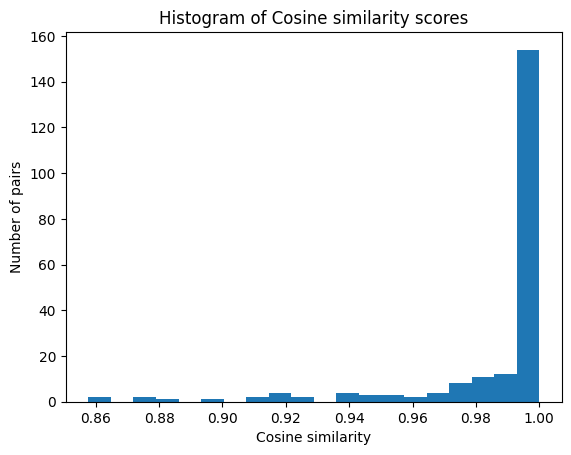

In [27]:
import matplotlib.pyplot as plt

cosine_scores = [score for (_, _, score) in cosine_pairs]
plt.hist(cosine_scores, bins=20)
plt.xlabel('Cosine similarity')
plt.ylabel('Number of pairs')
plt.title('Histogram of Cosine similarity scores')
plt.show()
